# Problem 2

## Andy Ham & Jay Dhanoa (aham-jdhanoa)

In [1]:
import re
import operator
import math
import string
import nltk
import cPickle
import time
import scipy
import cPickle
import csv
import numpy as np
from scipy import sparse
from operator import add
from scipy import sparse
from pyspark.sql import SparkSession, Row
from collections import Counter
from pprint import pprint

from sklearn.decomposition import NMF, LatentDirichletAllocation
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA

from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import udf

import matplotlib.pyplot as plt
%matplotlib inline

# (a) Generation of the vocabulary:

In [2]:
def clean_and_split(s):
    # encode to UTF-8, convert to lowercase and translate all hyphens and punctuation to whitespace
    if not s:
        return([])
    s = s.lower()
    s = re.sub(r'\<\/?.+?\>','',s)
    s = re.sub('['+re.escape(string.punctuation)+']','',s)
    # replace \r\n
    s = re.sub(r'([\r\n ])+',' ',s)
    # replace whitespace substrings with one whitespace and remove leading/trailing whitespaces
    return filter(lambda x: x!='', s.split(' '))

stopwords = set(nltk.corpus.stopwords.words('english'))

Read in Merged CSV file and create a dictionary

In [3]:
with open('/project/cmsc25025/stackexchange/20161215StatsPostsMerged.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    id_text_tuple = []
    just_text = []
    ct_merged = Counter()
    for row in readCSV:
        #id_text_tuple.append((row[0],clean_and_split(row[1].decode('utf-8'))))
        just_text.append(clean_and_split(row[1].decode('utf-8')))
        ct_merged.update(clean_and_split(row[1]))

Note that we used Python's built in CSV reader (as opposed to Spark's CSV reading methods) because of an issue we encountered with Spark's csv reader. If reading text in with spark, the cleanbody text would stop at the first comma in the cleanbody text.

In [4]:
def is_float(x):
    try:
        float(x)
        return True
    except:
        return False

for word in stopwords:
    del(ct_merged[word])

to_del = []
for word in ct_merged:
    if len(word)<3:
        to_del.append(word)
    else:
        if is_float(word):
            to_del.append(word)
            
for word in to_del:
    del(ct_merged[word])

In [5]:
vocabulary = sorted(map(lambda x: x[0], ct_merged.most_common(10250)[250:]))
vocabset = set(vocabulary)
vocabdict = {word:index for index, word in enumerate(vocabulary)}
vocabidict = {index:word for index, word in enumerate(vocabulary)}

We generated vocabulary by splitting the body text in the merged csvfile, and creating a dictionary. From that dictionary, we removed all words with a length less than 3 (to remove very simple/basic words, and numbers as topics). Excluding the 250 most common words also appeared to improve the quality of our data.

## (b)

Note that some of the code below has been broken up, just so that we don't have to repeatedly rerun unnecessary code, e.g. reading in a file from disk or declaring a new SparkSession. I've run into issues with repeatedly re-declaring Sparksessions causing the kernel to crash/become unresponsive.

In [6]:
def generate_tf_idf(text):
    split = clean_and_split(text)
    size = len(vocabulary)
    indexlist = []
    for word in split:
        if word in vocabset:
            indexlist.append(vocabdict[word])
    ct = Counter(indexlist)
    vec = Vectors.sparse(size, dict(ct))
# add a line above to make vec into a sparse matrix
    return vec

In [7]:
spark  = SparkSession.builder.config("spark.driver.maxResultSize", "20g")\
.master('local[28]').appName('mergedcsv').getOrCreate()

In [8]:
with open('/project/cmsc25025/stackexchange/20161215StatsPostsMerged.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    list_of_pairs = []
    i=0
    for i, row in enumerate(readCSV):
        if i!=0:
            list_of_pairs.append((row[0],row[1]))

In [9]:
rdd2 = spark.sparkContext.parallelize(list_of_pairs)

In [10]:
# rdd = mergedcsv_dataset.rdd
# mapped_rdd = rdd.map(lambda x: (x[0], generate_tf_idf(x[1])))

mapped_rdd = rdd2.map(lambda x: Row(Id=x[0], features=x[1])).map(lambda x: (x[0], generate_tf_idf(x[1])))
mapped_rdd.persist()

# splitting into training and validation sets
weights = [0.9, 0.1]
splits = mapped_rdd.randomSplit(weights)

train_df = splits[0].toDF(['id', 'features'])
train_df.persist()
validation_df = splits[1].toDF(['id', 'features'])
validation_df.persist()


df = mapped_rdd.toDF(['id', 'features']) #whole corpus


In [11]:
lda = LDA(k=30, maxIter=10)
model_train = lda.fit(train_df)

In [12]:
#taken from spark LDA documentation
ll = model_train.logLikelihood(df)
lp = model_train.logPerplexity(df)
print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
print("The upper bound bound on perplexity: " + str(lp))

The lower bound on the log likelihood of the entire corpus: -56775103.6418
The upper bound bound on perplexity: 8.1628679811


Note that the perplexity that we calculated is actually the *log* perplexity.

In [13]:
# 10 words per topic
topics_train = model_train.describeTopics(10)
print("The topics described by their top-weighted terms:")
topics_train.show(truncate=False)

# Shows the result
transformed = model_train.transform(df)
transformed.show(truncate=False)

The topics described by their top-weighted terms:
+-----+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                                 |termWeights                                                                                                                                                                                                                       |
+-----+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[7219, 7663, 8398, 8397, 6400, 6401, 2606, 6429, 7172, 

In [14]:
def index_to_word(termIndices):
    topic_words = []
    for index in termIndices:
        topic_words.append(vocabidict[index])
    return topic_words

In [15]:
show_words = topics_train.rdd.map(lambda x: (x[0], index_to_word(x[1])))

In [16]:
print ("Format is: (Topic number, [word1, word2, ... word10])")
pprint(show_words.take(30))

Format is: (Topic number, [word1, word2, ... word10])
[(0,
  ['raters',
   'reward',
   'splines',
   'spline',
   'particle',
   'particles',
   'divergence',
   'path',
   'rainfall',
   'agreement']),
 (1,
  ['words',
   'word',
   'documents',
   'document',
   'text',
   'topic',
   'classes',
   'lda',
   'classifier',
   'topics']),
 (2,
  ['gee',
   'paid',
   'unconditional',
   'conditional',
   'gmm',
   'coverage',
   'task',
   'mannwhitney',
   'september',
   'hospitals']),
 (3,
  ['age',
   'survival',
   'risk',
   'hazard',
   'cox',
   'gender',
   'study',
   'women',
   'height',
   'income']),
 (4,
  ['entropy',
   'tree',
   'decision',
   'trees',
   'gain',
   'node',
   'rain',
   'shannon',
   'robot',
   'rpart']),
 (5,
  ['instruments',
   'school',
   'instrument',
   'endogenous',
   'schools',
   '2sls',
   'exogenous',
   'stage',
   'pdf',
   'instrumental']),
 (6,
  ['events',
   'event',
   'odds',
   'chance',
   'balls',
   'red',
   'trials',
   '

These topics seem pretty good. Topic 1 is about topic modeling with lda, words, docs, and text, topic 6 about probabilities and events, topic 7 about neural networks, topic 21 about clustering, topic 25 about poisson/binomial distributions, topic 27 about gaussian functions, etc.

In [17]:
num_docs = 10
num_topics = 5

def topic_weight_pair(topicDistribution):
    tup_list = []
    print len(topicDistribution)
    for i, weight in enumerate(topicDistribution):
        tup_list.append((i, weight))
    tup_list = sorted(tup_list, key=lambda x: x[1], reverse=True)
    return tup_list[:num_topics]

transformed = model_train.transform(validation_df)
transformed_mapped = transformed.rdd.map(lambda x: (x[0], topic_weight_pair(x[2])))
print "format is: (Document id, [(Topic number, Topic weight)...])"
transformed_mapped.take(10)

DataFrame[id: string, features: vector, topicDistribution: vector]
PythonRDD[153] at RDD at PythonRDD.scala:48
format is: (Document id, [(Topic number, Topic weight)...])


[(u'35',
  [(25, 0.98286739625462671),
   (19, 0.00063330616081520906),
   (27, 0.00062709043014749289),
   (13, 0.00060953619012153759),
   (26, 0.00059984031100880609)]),
 (u'73',
  [(12, 0.39062294285969373),
   (25, 0.26186513328982536),
   (19, 0.2012703181031108),
   (17, 0.054671643055427016),
   (8, 0.053859939773109905)]),
 (u'168',
  [(17, 0.47402138640382097),
   (27, 0.22429793754803376),
   (21, 0.21857956359511985),
   (8, 0.070809467591203573),
   (25, 0.00054852927016770762)]),
 (u'192',
  [(25, 0.78028714545723887),
   (19, 0.12299541684924782),
   (13, 0.037666991663307302),
   (20, 0.029383813815489032),
   (18, 0.027896804926299361)]),
 (u'249',
  [(25, 0.65314847839422219),
   (26, 0.3353426554382633),
   (19, 0.00044086010646963286),
   (27, 0.00043653318236348343),
   (13, 0.00042431324105176785)]),
 (u'256',
  [(8, 0.41767630088402091),
   (27, 0.3264366677257356),
   (23, 0.24726093977677455),
   (25, 0.00037102873864800975),
   (19, 0.00034143076839490667)]),


These seem to be someone accurate. For example, document 35 is heavily weighted for Topic 25, and they both concern poisson/binomial distributions: 


35,"Modelling a Poisson distribution with overdispersion I have a data set that I'd expect to follow a Poisson distribution, but it is overdispersed by about 3-fold. At the present, I'm modelling this overdispersion using something like the following code in R.     Visually, this seems to fit my empirical data very well. If I'm happy with the fit, is there any reason that I should be doing something more complex, like using a negative binomial distribution, as described here? (If so, any pointers or links on doing so would be much appreciated).  Oh, and I'm aware that this creates a slightly jagged distribution (due to the multiplication by three), but that shouldn't matter for my application.  Update:  For the sake of anyone else who searches and finds this question, here's a simple R function to model an overdispersed poisson using a negative binomial distribution. Set d to the desired mean/variance ratio:     (via the R mailing list:   If your mean value for the Poisson is 1500, then you're very close to a normal distribution; you might try using that as an approximation and then modelling the mean and variance separately. for overdispersed poisson, use the negative binomial, which allows you to parameterize the variance as a function of the mean precisely.  rnbinom(), etc. in R."

# (c)


We're given two definitions of perplexity:

$$ \text{Perplexity}(\theta) = \left( \prod_{D} p_\theta(D)\right)^\frac{-1}{\sum_{D}|D|} $$

and

$$ \text{Perplexity}(\theta) = \left( \prod_{n=1}^{N}p_\theta (w_n | w_1,...,w_{n-1}) \right)^{\frac{-1}{N}} $$

We can think of $p_\theta (D)$ as $p_\theta (\text{word sequence constituting }D)$. In other words, our document is going to be a sequence of words, each of which we can think of as being probabilistically contingent on the previous examples. Thusly, we're going to have $p_\theta(w_1) \times p_\theta(w_2 | w_1 ) \times ... \times p_\theta(w_n | w_1, ..., w_{n-1})$, which is effectively $\prod_{n=1}^{N}p_\theta (w_n | w_1,...,w_{n-1})$.

A straightforward approach is computationally difficult because calculation of $p(w_n)$ for a single document given our topic matrix and hyperparameter $\alpha$ is a computationally intractable problem.

An efficient computational solution is to instead calculate the log of the perplexity:

$$ \log \left( \left( \prod_{n=1}^{N}p_\theta (w_n | w_1,...,w_{n-1}) \right)^{\frac{-1}{N}} \right) \\
\frac{-1}{N} \sum_{n=1}^{N} \log p_\theta (w_n | w_1, ..., w_{n-1})$$

Which is just taking the sum of the log likelihoods, and dividing by the number of tokens.

# (d)

In [19]:
logger = spark.sparkContext._jvm.org.apache.log4j
logger.LogManager.getLogger("org"). setLevel( logger.Level.ERROR )
logger.LogManager.getLogger("akka").setLevel( logger.Level.ERROR )

In [20]:
K_1 = range(10, 110, 10)
K_2 = range(110, 210, 10)
perplexity_list_1 = []
perplexity_list_2 = []

for numtopics in K_1:
    start = time.time()
    lda = LDA(k=numtopics, maxIter=10)
    model_train = lda.fit(train_df)
    lp = model_train.logPerplexity(validation_df)
    print lp
    perplexity_list_1.append(lp)
    end = time.time()
    print("{0:.2f} s".format(end-start))

8.36281610932
12.48 s
8.6822250357
17.84 s
9.08193516735
21.55 s
9.50748100889
26.31 s
9.96163555277
32.00 s
10.4709399944
36.72 s
10.9895377234
41.38 s
11.5106966149
45.77 s
12.0666465554
50.32 s
12.6271820915
55.16 s


Loss appears to be monotonically increasing. Runtimes are acceptable though, and understandably increase as the number of topics to model increase.

In [21]:
for numtopics in K_2:
    lda = LDA(k=numtopics, maxIter=10)
    model_train = lda.fit(train_df)
    lp = model_train.logPerplexity(validation_df)
    print lp
    perplexity_list_2.append(lp)

13.1960841035
13.789608315
14.3826781557
15.0104089008
15.6078210199
16.2637002506
16.89886894
17.5263969592
18.2180628325
18.8729318011


<function matplotlib.pyplot.show>

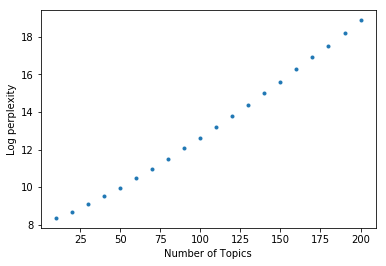

In [22]:
perplexity_list_3 = perplexity_list_1 + perplexity_list_2
K_3 = K_1 + K_2

plt.plot(K_3,perplexity_list_3, '.')
plt.xlabel('Number of Topics')
plt.ylabel('Log perplexity')
plt.show

From talking to other groups/general discussion, perplexity appears to monotonically increase over number of topics.

In [24]:
K_small = range(2, 10, 1)
perplexity_list_small =[]
for numtopics in K_small:
    start = time.time()
    lda = LDA(k=numtopics, maxIter=10)
    model_train = lda.fit(train_df)
    lp = model_train.logPerplexity(validation_df)
    print lp
    perplexity_list_small.append(lp)
    end = time.time()
    print("{0:.2f} s".format(end-start))

8.25051211991
9.17 s
8.24166975691
8.65 s
8.23456808806
8.75 s
8.25309284211
9.72 s
8.26964702402
10.77 s
8.29183372616
10.90 s
8.30899806806
11.15 s
8.32852500446
12.20 s


<function matplotlib.pyplot.show>

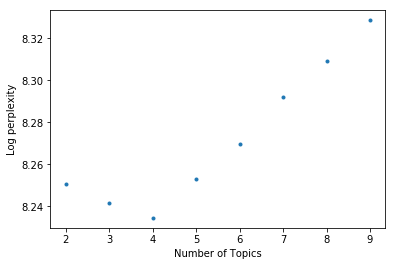

In [25]:
plt.plot(K_small,perplexity_list_small, '.')
plt.xlabel('Number of Topics')
plt.ylabel('Log perplexity')
plt.show

From these two plots we can see the model that fits the data the best is when K, the number of topics, is set to 4. That is when perplexity is the lowest, and the perplexity only monotonically increases with more topics.

In [11]:
lda_10 = LDA(k=10, maxIter=10)
lda_60 = LDA(k=60, maxIter=10)
lda_100 = LDA(k=100, maxIter=10)

model_train_10 = lda_10.fit(train_df)
model_train_60 = lda_60.fit(train_df)
model_train_100 = lda_100.fit(train_df)

In [13]:
topics_train_10 = model_train_10.describeTopics(10)
topics_train_60 = model_train_60.describeTopics(10)
topics_train_100 = model_train_100.describeTopics(10)

In [14]:
show_words_10 = topics_train_10.rdd.map(lambda x: (x[0], index_to_word(x[1])))
show_words_60 = topics_train_60.rdd.map(lambda x: (x[0], index_to_word(x[1])))
show_words_100 = topics_train_100.rdd.map(lambda x: (x[0], index_to_word(x[1])))

In [15]:
print ("Format is: (Topic number, [word1, word2, ... word10])")
pprint(show_words_10.take(10))

Format is: (Topic number, [word1, word2, ... word10])
[(0,
  ['book',
   'player',
   'course',
   'missing',
   'theory',
   'price',
   'players',
   'students',
   'books',
   'game']),
 (1,
  ['clustering',
   'cluster',
   'posterior',
   'kernel',
   'gaussian',
   'pca',
   'state',
   'machine',
   'clusters',
   'space']),
 (2,
  ['estimator',
   'intervals',
   'maximum',
   'estimated',
   'conditional',
   'missing',
   'pvalue',
   'equation',
   'constant',
   'estimation']),
 (3,
  ['items',
   'outcome',
   'survival',
   'ordinal',
   'categorical',
   'age',
   'mixed',
   'item',
   'predictor',
   'levels']),
 (4,
  ['ttest',
   'tree',
   'poisson',
   'outliers',
   'significance',
   'forest',
   'trees',
   'pvalue',
   'count',
   'table']),
 (5,
  ['transformation',
   'square',
   'squared',
   'squares',
   'freedom',
   'transform',
   'degrees',
   'categorical',
   'transformed',
   'log']),
 (6,
  ['events',
   'odds',
   'chance',
   'event',
   'probab

In [16]:
print ("Format is: (Topic number, [word1, word2, ... word10])")
pprint(show_words_60.take(60))

Format is: (Topic number, [word1, word2, ... word10])
[(0,
  ['theta',
   'census',
   'equation',
   'probabilities',
   'exact',
   'tables',
   'capita',
   'book',
   'tracts',
   'per']),
 (1,
  ['bot',
   'markov',
   'mcnemar',
   'marketing',
   'classes',
   'mle',
   'hidden',
   'state',
   'algorithms',
   'proportions']),
 (2,
  ['normalization',
   'brownian',
   'motion',
   'julia',
   'gee',
   'profit',
   'tasks',
   'fuel',
   'star',
   'task']),
 (3,
  ['substance',
   'squares',
   'constraints',
   'pizza',
   'wet',
   'common',
   'ordinal',
   'outcome',
   'derivatives',
   'customer']),
 (4,
  ['counts',
   'estimator',
   'embeddings',
   'space',
   'diseases',
   'word',
   'poisson',
   'table',
   'report',
   'known']),
 (5,
  ['rain',
   'generative',
   'bucket',
   'eta',
   'replicates',
   'discriminative',
   'buckets',
   'variational',
   'strain',
   'stouffers']),
 (6,
  ['entropy',
   'balls',
   'odds',
   'white',
   'ball',
   'red',
   

In [17]:
print ("Format is: (Topic number, [word1, word2, ... word10])")
pprint(show_words_100.take(100))

Format is: (Topic number, [word1, word2, ... word10])
[(0,
  ['sick',
   'probabilities',
   'tables',
   'healthy',
   'player',
   'segment',
   'slope',
   'exact',
   'kernel',
   'machine']),
 (1,
  ['alcohol',
   'siblings',
   'importance',
   'classifier',
   'sibling',
   'colinearity',
   'mosaic',
   'decision',
   'defined',
   'association']),
 (2,
  ['tasks',
   'task',
   'completion',
   'ties',
   'star',
   'late',
   'participants',
   'meter',
   'percentage',
   'pearson']),
 (3,
  ['substance',
   'pizza',
   'predict',
   'survived',
   'quantile',
   'wet',
   'dummy',
   'nonlinearity',
   'assumptions',
   'coding']),
 (4,
  ['equipment',
   'mars',
   'visualization',
   'report',
   'hilbert',
   'column',
   'properties',
   'odds',
   'curves',
   'performance']),
 (5,
  ['bucket',
   'eta',
   'tax',
   'replicates',
   'sales',
   'buckets',
   'kernel',
   'strain',
   'growth',
   'robust']),
 (6,
  ['entropy',
   'balls',
   'white',
   'ball',
   're

Qualitatively, we can see that as the number of topics increase, the words in each topic tend to be more closely related. It makes sense since we're finding smaller clusters thus the words have to be in very similar to be considered in the same topic. Like topic 73 in K=100 model is mostly derivations of the word "cause" like causes, causation, casuality, etc., whereas in the model with K=10, topic 0 contains book, player, course, missing, theory, which to me do not seem very related